# Object Classification Transfer Learning with only pytorch
In this notebook, we would apply transfer learning techniques for image classification tasks can be viewed as a sequence of three steps as below.


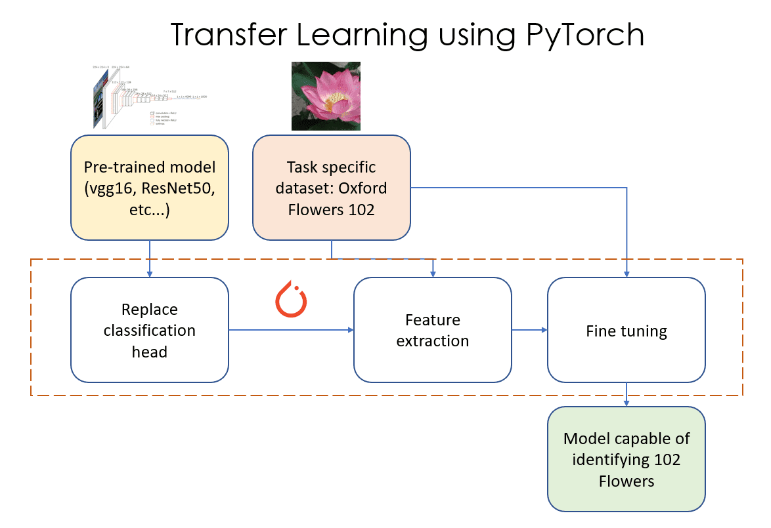


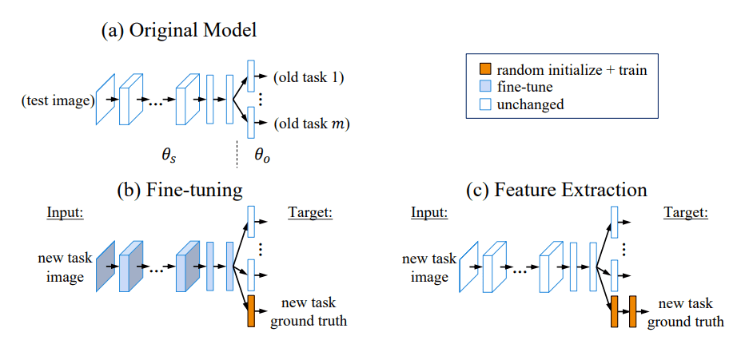


# Transfer Learning Techniques
1. **Fine tuning** 
    1. Instantiating a Pre-Trained Model with Weights
    Initialize a pre-trained model with its pre-existing weights.


    2. Replacing Classifier Heads
    Replace the output layer (also known as the classifier head) with a new one that corresponds to the number of categories in our target dataset. 


    3. Fine-Tuning the Model
    Train the new model on our target dataset. During fine-tuning, the parameters of all layers are adjusted to optimize performance on our specific task. 

1. **Fine tuning** 
    1. Instantiating a Pre-Trained Model with Weights
    Initialize a pre-trained model with its pre-existing weights.


    2. Replacing Classifier Heads
    Replace the output layer with a new one that corresponds to the number of categories in our target dataset.


    3. Task-Specific Training
    Freeze all the layers from the pre-trained model, leaving only the outer layer (classifier head) to be trained.


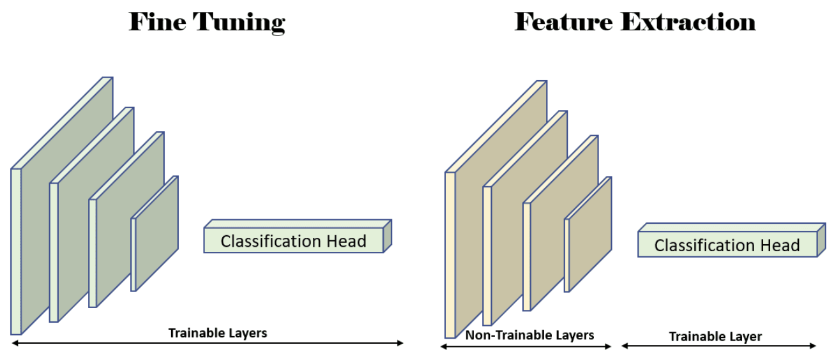

In [1]:
%%capture
!pip install -r ../requirements.txt

# Libraries

In [2]:
import torch
from torch import nn
import torch.quantization
import numpy as np
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
from torchinfo import summary

from torch.utils.data import ConcatDataset

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data
- We can access several datasets modules from torch vision, this includes all the popular datasets like MNIST, CIFAR10, CIFAR100, ImageNet, etc.
- The dataset files are already labeled and arranged in a compatible manual with Torch vision
  - jpg files - raw image files
  - image label.mat - labels of the image files
- If you are loading datasets manually, it might be worthwhile to investigate available the datasets/loader file structure.

In [4]:
# Loading train and val datasets, to be used as validation datasets
train_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="train",
    transform=torchvision.transforms.Compose(
        [torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()]
    ),
)

val_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="val",
    transform=torchvision.transforms.Compose(
        [torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()]
    ),
)

# Using the test data as training data, will be applying data augmentation for it.
# Utilize data augmentation techniques on the training data to prevent overfitting
# and allow the model to learn the features so that it can perform predictions on unseen data.
# - Color Jitter
# - Horizontal Flip
# - Rotation
# - Shear
test_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="test",
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
            torchvision.transforms.RandomAffine(degrees=30, shear=20),
            torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
        ]
    ),
)

flower_test_dataset = ConcatDataset([train_data, val_data])  # as trainval dataset
flower_train_dataset = test_data  # as training datasets

# Number of datasets
print("Number of training datasets: ", len(flower_train_dataset))
print("Number of test datasets: ", len(flower_test_dataset))

Number of training datasets:  6149
Number of test datasets:  2040


If the interest if of best accuracy, it may be worthwhile to use test/val/train split for training. This is not used here as our focus is to showcase training with fine-tuning/transfer setup here.

If you have your own datasets and pre-trained models to use, you might need to modify/tweak the dataloader so that the images and its label are read correctly.

## Image Dataloader setup

In [5]:
image_datasets = {}
image_datasets["train"] = flower_train_dataset
image_datasets["val"] = flower_test_dataset
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

## Plotting the dataset images

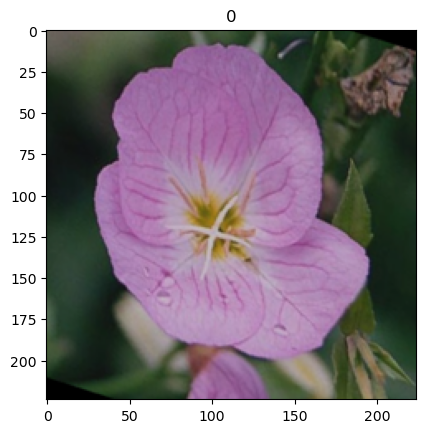

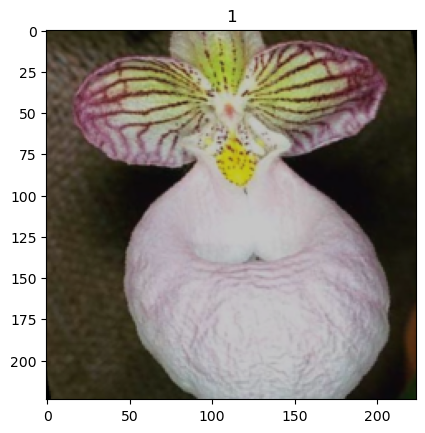

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


imshow(flower_train_dataset[0][0], title=flower_train_dataset._labels[0])
imshow(flower_train_dataset[50][0], title=flower_train_dataset._labels[50])

## Number of labels and label types

In [7]:
from collections import Counter
import seaborn as sns

print("Number of unique labels: ", len(Counter(flower_train_dataset._labels)))
print("Number of images: ", len(flower_train_dataset._labels))

Number of unique labels:  102
Number of images:  6149


# Load the pretrained model
- examples of loading some pre-trained models that is available on torchvision and also depicting their classifier head

In [8]:
# Load pre-trained models, by default all of the models are trained and tested on ImageNet dataset (with 1000 classes)
vgg16 = torchvision.models.vgg16_bn(weights=None)
resnet50 = torchvision.models.resnet50(weights=None)
resnet152 = torchvision.models.resnet152(weights=None)


# we can examine the last layer of the model via the following code
print("vgg16\n", vgg16.classifier)
print("resnet50\n", resnet50.fc)
print("resnet152\n", resnet152.fc)

vgg16
 Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
resnet152
 Linear(in_features=2048, out_features=1000, bias=True)


# Setup: Learning Rates + Layers

## Feature Extraction - Setup

We would require only a learning rate on the classifier head.

- Loading a specific pre-train model
- Modifying the classifier head only

In [9]:
pretrained_model_tl = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)

for param in pretrained_model_tl.parameters():
    param.requires_grad = False

print("Original")
print("\t resnet50\n", pretrained_model_tl.fc)

classifier_layers = [pretrained_model_tl.fc]
# Parameters of newly constructed modules have requires_grad=True by default
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
pretrained_model_tl.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
new_layers = [pretrained_model_tl.fc]

print("Modified")
print("\tresnet50\n", pretrained_model_tl.fc)

# to device
model_ft = pretrained_model_tl.to(device)

# this reliea on torch info package, which would summarize the model and print the model layers (similar to keras)
summary(
    pretrained_model_tl,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Original
	 resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
Modified
	resnet50
 Linear(in_features=2048, out_features=102, bias=True)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 102]                 --                        Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False


Note that only the last layer is trainable

In [10]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_tl = optim.SGD(pretrained_model_tl.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_tl = lr_scheduler.StepLR(optimizer_tl, step_size=7, gamma=0.1)

## Fine Tuning - Setup
Here, we are simple modififying the the final layer to corresponds to our expected output class.


**On Learning Rate**
- Here we are setting it to a small constant. 

There are some that believe in decaying the learning rates as we move up the model towards the initial layers of the model because those initial layers have learnd basic features about the image (edge, patterns). The basic image features are thought to be common for most vision AI tasks.

Thus, the initial layers are trained with low LR to avoid perturbing what they leaned. For layers towards the classification head, we would need higher LR so that the models would learn more task specific.


In [11]:
pretrained_model_ft = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)
classifier_layers = [pretrained_model_ft.fc]
# Parameters of newly constructed modules have requires_grad=True by default
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
pretrained_model_ft.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
new_layers = [pretrained_model_ft.fc]

# to device
model_ft = pretrained_model_ft.to(device)

# this reliea on torch info package, which would summarize the model and print the model layers (similar to keras)
summary(
    pretrained_model_ft,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 102]                 --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    │ 

Note that all layers is trainable

In [12]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observethat all parameters are being optimized
# and that it is decay per layers
optimizer_ft = optim.SGD(pretrained_model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train Functions

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        epoch_dict = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
        }
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                if phase == "train":
                    epoch_dict["train_loss"].append(epoch_loss)
                    epoch_dict["train_accuracy"].append(epoch_acc.item())
                else:
                    epoch_dict["val_loss"].append(epoch_loss)
                    epoch_dict["val_accuracy"].append(epoch_acc.item())

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, epoch_dict

In [14]:
model_tl, epoch_dict_tl = train_model(
    pretrained_model_tl, criterion, optimizer_tl, exp_lr_scheduler_tl, num_epochs=10
)

Epoch 0/9
----------
train Loss: 4.0136 Acc: 0.1924
val Loss: 4.0363 Acc: 0.2044

Epoch 1/9
----------
train Loss: 3.2754 Acc: 0.3832
val Loss: 3.5840 Acc: 0.2946

Epoch 2/9
----------
train Loss: 2.7898 Acc: 0.4706
val Loss: 3.2701 Acc: 0.3667

Epoch 3/9
----------
train Loss: 2.4140 Acc: 0.5464
val Loss: 2.6683 Acc: 0.4461

Epoch 4/9
----------
train Loss: 2.1553 Acc: 0.6004
val Loss: 2.5912 Acc: 0.4838

Epoch 5/9
----------
train Loss: 1.9435 Acc: 0.6510
val Loss: 2.4506 Acc: 0.5353

Epoch 6/9
----------
train Loss: 1.7781 Acc: 0.6853
val Loss: 2.1914 Acc: 0.5779

Epoch 7/9
----------
train Loss: 1.6938 Acc: 0.7068
val Loss: 1.9613 Acc: 0.5995

Epoch 8/9
----------
train Loss: 1.6771 Acc: 0.6977
val Loss: 2.3018 Acc: 0.5667

Epoch 9/9
----------
train Loss: 1.6432 Acc: 0.7183
val Loss: 2.1128 Acc: 0.6034

Training complete in 10m 4s
Best val Acc: 0.603431


In [15]:
model_ft, epoch_dict_ft = train_model(
    pretrained_model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft, num_epochs=10
)

Epoch 0/9
----------
train Loss: 2.7280 Acc: 0.4045
val Loss: 1.2520 Acc: 0.6588

Epoch 1/9
----------
train Loss: 0.7684 Acc: 0.8112
val Loss: 0.5141 Acc: 0.8529

Epoch 2/9
----------
train Loss: 0.3978 Acc: 0.8990
val Loss: 0.3320 Acc: 0.9025

Epoch 3/9
----------
train Loss: 0.2330 Acc: 0.9418
val Loss: 0.2427 Acc: 0.9289

Epoch 4/9
----------
train Loss: 0.1616 Acc: 0.9623
val Loss: 0.2681 Acc: 0.9211

Epoch 5/9
----------
train Loss: 0.1364 Acc: 0.9686
val Loss: 0.1945 Acc: 0.9471

Epoch 6/9
----------
train Loss: 0.0980 Acc: 0.9784
val Loss: 0.2078 Acc: 0.9431

Epoch 7/9
----------
train Loss: 0.0662 Acc: 0.9870
val Loss: 0.1900 Acc: 0.9495

Epoch 8/9
----------
train Loss: 0.0639 Acc: 0.9878
val Loss: 0.2008 Acc: 0.9456

Epoch 9/9
----------
train Loss: 0.0585 Acc: 0.9878
val Loss: 0.1818 Acc: 0.9495

Training complete in 15m 20s
Best val Acc: 0.949510


# Result
- visualize results of the model

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

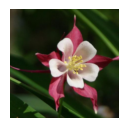

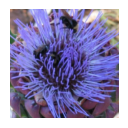

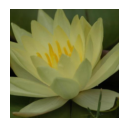

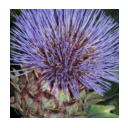

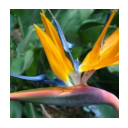

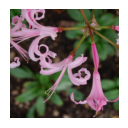

In [18]:
visualize_model(model_ft)

1. With feature extraction step alone, almost all the networks have an accuracy between 91% and 94%
2. Almost all networks do really well, achieving an accuracy of 96+% after the fine-tuning step. This shows that the fine tuning step really helps during transfer learning.

In [32]:
train_accuracy_tl = [float(tensor) for tensor in epoch_dict_tl['train_accuracy']]
val_accuracy_tl = [float(tensor) for tensor in epoch_dict_tl['val_accuracy']]

In [29]:
train_accuracy_fe = [float(tensor) for tensor in epoch_dict_ft['train_accuracy']]
val_accuracy_fe = [float(tensor) for tensor in epoch_dict_ft['val_accuracy']]

Text(0.5, 1.0, 'Fine_tuning -\n  Train Accuracy vs Val Accuracy')

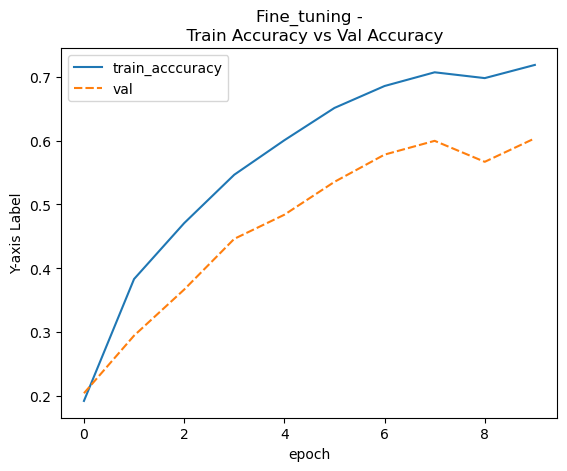

In [42]:
sns.lineplot({'train_acccuracy':train_accuracy_tl, 'val':val_accuracy_tl})

# Add labels and title
plt.xlabel("epoch")
plt.ylabel("Y-axis Label")
plt.title("Fine_tuning -\n  Train Accuracy vs Val Accuracy")

Text(0.5, 1.0, 'Train Accuracy vs Val Accuracy')

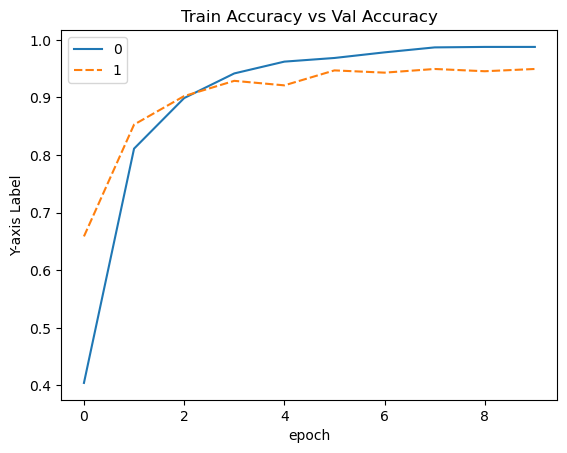

In [41]:
sns.lineplot([train_accuracy_fe, val_accuracy_fe])

# Add labels and title
plt.xlabel("epoch")
plt.ylabel("Y-axis Label")
plt.title("Feature_extraction -\n  Train Accuracy vs Val Accuracy")

# Exercise
1. Can you modified the code to use VGG16 model instead of ResNet50 for Tf and fine-tuning
2. Any siginificant differences?

# References
1. https://www.kdnuggets.com/2023/06/practical-guide-transfer-learning-pytorch.html
2. https://github.com/dhruvbird/ml-notebooks/blob/main/Flowers-102-transfer-learning/flowers102-classification-using-pre-trained-models.ipynb
3. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet